# Project 4 - Part 2 Twitter Data

Gorkem Camli (105709280)

#### Library imports

In [1]:
import pandas as pd
import json
import pytz
import datetime



import re
import collections
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import os.path

import warnings
warnings.filterwarnings('ignore')

In [99]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

In [3]:
import nltk

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gorkemcamli/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Read Data

In [4]:
repo_name = 'ECE219_tweet_data/'
file_names= ['tweets_#gohawks.txt',
             'tweets_#gopatriots.txt',
             'tweets_#nfl.txt',
             'tweets_#patriots.txt',
             'tweets_#sb49.txt',
             'tweets_#superbowl.txt'
]

df_names = []
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    df_names.append(file_name_key)

In [5]:
def read_txt_file(fname):
    "takes too long for the last sb49 and superbowl txt files"
    with open(fname) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']
    df_inter['json_element'].apply(json.loads)
    df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))    
    return df_final

def read_txt_file2(fname):
    "read line by line and get only what you need for Q27 and Q28"
    df_dict = collections.defaultdict(list)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            df_dict['title'].append(tweet['title'])
            df_dict['citation_date'].append(tweet['citation_date'])
            df_dict['retweet_count'].append(tweet['metrics']['citations']['total']) 
            df_dict['followers_count'].append(tweet['author']['followers'])

    df_final = pd.DataFrame(df_dict)
    return df_final

In [6]:
TIME_ZONE = 'US/Pacific'
PST_TZ = pytz.timezone(TIME_ZONE) # PST time zone 

## Question 27

__Report the following statistics for each hashtag, i.e. each file.__

• Average number of tweets per hour

• Average number of followers of users posting the tweets per tweet (to make it simple, we average over the number of tweets; if a users posted twice, we count the user and the user’s followers twice as well)

• Average number of retweets per tweet


In [7]:
tweet_dfs = {}
for file_name in file_names:
    file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
    tweet_dfs[file_name_key] = read_txt_file2(fname=repo_name+file_name)
    print(file_name_key, tweet_dfs[file_name_key].shape)
    #display(tweet_dfs[file_name_key].head(3))

gohawks (169122, 4)
gopatriots (23511, 4)
nfl (233022, 4)


KeyboardInterrupt: 

In [ ]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    cur_df['citation_date_fixed'] = cur_df.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(x, PST_TZ)) 
    cur_df[new_cols] = cur_df.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    cur_df['citation_date_rounded_hour']= cur_df.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
  

In [ ]:
def avg_tweet_per_hour(df):
    cols_group = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    return df.groupby(by=cols_group).title.count().mean()

def avg_num_followers(df):
    '''
    Average number of followers of users posting the tweets per tweet 
    (to make it simple, we average over the number of tweets; 
    if a users posted twice, we count the user and the user’s followers twice as well)
    '''
    avg_followers = df['followers_count'].mean()
    return avg_followers

def avg_retweet_per_tweet(df):
    return df['retweet_count'].mean()

In [ ]:
for df_name in df_names:
    cur_df = tweet_dfs[df_name]
    
    print(f'\n\n--- Stats for #{df_name} ---')
    avg_twt = avg_tweet_per_hour(cur_df)
    print('Average # tweet per hour', round(avg_twt,3))
    
    avg_flws = avg_num_followers(cur_df)
    print('Average # followers', round(avg_flws,3))
    
    avg_retweet_per_twt = avg_retweet_per_tweet(cur_df)
    print('Average # retweet per tweet', round(avg_retweet_per_twt,3))

## Question 28

__Plot “number of tweets in hour” over time for #SuperBowl and #NFL (a bar plot with 1-hour bins). The tweets are stored in separate files for different hashtags and files are named as tweet [#hashtag].txt.__

In [ ]:
def plot_num_tweet_per_hour(df, df_name, x_ticks_freq=10):
    cols = ['citation_date_rounded_hour']
    gp_df = pd.DataFrame(df.groupby(by=cols).title.count())
    gp_df.sort_index(inplace=True)
    #gp_df.reset_index(inplace=True)
    gp_df.rename(columns={'title':'tweet_count_per_hour'}, inplace=True)
    
    ax = gp_df.plot(kind='bar',figsize=(30,7), rot=90)
    plt.title(f'{df_name} Bar Plot for Number of Tweets in hour over time')
    ax.set_ylabel('Tweet Count Per Hour')
    ax.set_xlabel('Citation Date')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text()[:-9] for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::x_ticks_freq])
    ax.xaxis.set_ticklabels(ticklabels[::x_ticks_freq])
    plt.show()
    
    


In [ ]:
for df_name in ['superbowl','nfl']:
    cur_df = tweet_dfs[df_name]
    plot_num_tweet_per_hour(cur_df, df_name, x_ticks_freq=20)

## Question 29

### Task Explanation

Follow the steps outlined below: 

- Describe your task.
- Explore the data and any metadata (you can even incorporate additional datasets if you choose).
- Describe the feature engineering process. Implement it with reason: Why are you extracting features this way - why not in any other way?
- Generate baselines for your final ML model.
- A thorough evaluation is necessary.
- Be creative in your task design - use things you have learned in other classes too if you are excited about them!

__Intro:__

In this design question I explored the twitter dataset from several different point of views: sentiment analysis, fan prediction and impression prediction.

The main objective is to understand which different ways we can consume the Twitter data.

__Task Description:__


__Subtasks:__

- Task 1: Character-centric time-series tracking: average perceived emotion across tweets about each player in the game across time in each fan base? Can we correlate these emotions with the team winning game?

- Task 2: With user and tweet meta data, can we predict the hashtag used?

- Task 3: TBD predict impressions

__Data Used:__

- '#gopatriots.csv' and '#gohawks.csv' files.
-  Additional data: 
    - Players information: I collected team player names, positions, position category information for Patriots and Seahawks team members who played at Superbowl 49.  
    - Game information: I used the score plays information to extract relative score times from tweets and label which team is the leading the game (patriots, sehawks, tie) when a tweet posted.


__Feature Engineering__

- emotion data
- label
- player data

__Prediction Models__
- Baselines
- Models


### __Data Preparation__

##### __Set GAME_START and GAME_END times__

In [182]:
# set naive datetime correctly
# (Add timezone to a naive datetime) from : https://medium.com/@eleroy/10-things-you-need-to-know-about-date-and-time-in-python-with-datetime-pytz-dateutil-timedelta-309bfbafb3f7

GAME_START = datetime.datetime(2015, 2, 1, 15, 30, 0, 0)
GAME_START = PST_TZ.localize(GAME_START)

GAME_END = datetime.datetime(2015, 2, 1, 19, 6, 0, 0)
GAME_END = PST_TZ.localize(GAME_END)
print('GAME_START',GAME_START)
print('GAME_END',GAME_END)

GAME_START 2015-02-01 15:30:00-08:00
GAME_END 2015-02-01 19:06:00-08:00


##### Helper functions

(to prepare data  extract features, feature engineering and prepare the dataset to be used in the tasks)

In [9]:
def read_q29_raw_data():
    tweet_dfs2 = {}
    for file_name in ['tweets_#gohawks.txt','tweets_#gopatriots.txt']:
        file_name_key = file_name[file_name.find('#')+1: file_name.find('.')]
        tweet_dfs2[file_name_key] = read_txt_file(fname=repo_name+file_name)
        print(file_name_key, tweet_dfs2[file_name_key].shape)
        #display(tweet_dfs[file_name_key].head(3))

    tweet_dfs2['gohawks']['hashtag'] = '#gohawks'
    tweet_dfs2['gopatriots']['hashtag'] = '#gopatriots'
    return tweet_dfs2

In [10]:
def clean_mentions_links(text):
    # clean mentions and links
    # mention count, link count, hashtag count
    
    mention_count = 0
    hashtag_count = 0
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        if t.startswith('@') and len(t) > 1:
            mention_count+=1
        if t.startswith('#') and len(t) > 1:
            hashtag_count+=1
            
        t = '' if t.startswith('@') and len(t) > 1 else t #'@user'
        t = '' if t.startswith('http') else t  #'http' 
        new_text.append(t)
    return [" ".join(new_text), mention_count, hashtag_count]

def clean_hashtag(text):
    # clean hashtag
    new_text = []
    text_lower = text.lower()
    for t in text_lower.split(" "):
        t = '' if t.startswith('#') and len(t) > 1 else t #'@user'
        new_text.append(t)
    return " ".join(new_text)


def find_players_listed_in_tweet(tweet):
    players = []
    tweet_lower = tweet.lower()
    for player in list(players_df.Player.unique()):
        player_lower = player.lower()
        player_first, player_last = player_lower.split(' ')[0], player_lower.split(' ')[-1]
        
        if player_lower in tweet_lower or player_first in tweet_lower or player_last in tweet_lower:
            players.append(player)
    return None if not players else players

def game_interval(twt_time):
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < GAME_END:
        return 'during_game'
    else:
        return 'after_game'


In [73]:
def assign_nltk_sentiment_label(compound):
    # reference: https://github.com/cjhutto/vaderSentiment#about-the-scoring
    label=None
    if compound >= 0.05:
        label='positive'
    elif (compound > -0.05) & (compound <0.05):
        label='neutral'
    else:
        label='negative'
    return label

def nltk_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_nltk_vader_'
    col_names = [prefix+'neg'+post_fix, prefix+'neu'+post_fix,prefix+'pos'+post_fix,prefix+'compound'+post_fix]
    
    if col_names[-1] in data.columns:
        return data
    else:
        sia = SentimentIntensityAnalyzer()
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(sia.polarity_scores(x)))
        data['sent_nltk_vader_label'+post_fix] =  data['sent_nltk_vader_compound'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data

def textblob_sentiment(data, tweet_feature_name='title'):
    post_fix = '_'+tweet_feature_name
    prefix ='sent_textblob_'
    col_names = [prefix+'polarity'+post_fix, prefix+'subjectivity'+post_fix]

    if col_names[0] in data.columns:
        return data
    else:
        data[col_names] = data[tweet_feature_name].apply(lambda x: pd.Series(TextBlob(x).sentiment))
        data[prefix+'label'+post_fix] =  data[prefix+'polarity'+post_fix].apply(lambda x: assign_nltk_sentiment_label(x))
        return data


In [53]:
def date_time_fix(data):
    # prep posting time
    print('Starting posting time datetime features...')
    new_cols = ['citation_date_year', 'citation_date_month','citation_date_day','citation_date_hour']
    data['citation_date_fixed'] = data.citation_date.apply(lambda x:  datetime.datetime.fromtimestamp(int(x), PST_TZ)) 
    data[new_cols] = data.apply(lambda x: [x['citation_date_fixed'].year, x['citation_date_fixed'].month,
                                               x['citation_date_fixed'].day, x['citation_date_fixed'].hour], axis=1, result_type='expand')
    data['citation_date_rounded_hour']= data.citation_date_fixed.apply(lambda x: x.replace(second=0, microsecond=0, minute=0))
 
    return data

def prep_tweet_emotion_data(tweet_dfs2):
    fname = 'data/tweet_emt_df.csv'
    #print('Creating tweet_dfs2...')
    #tweet_dfs2 = read_q29_raw_data()
    if os.path.isfile(fname):
        tweet_emt_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        return tweet_emt_df
    else:  
        # create tweet_emt_df
        print('Starting tweet_emt_df...')
        cols = ['title', 'tweet.text', 'citation_date','hashtag', 'tweet.lang', 'tweet.user.name', 'original_author.name',
                'tweet.entities.hashtags','tweet.entities.user_mentions','tweet.retweet_count','tweet.favorite_count',
                'tweet.user.followers_count','tweet.user.friends_count','tweet.user.favourites_count','author.followers',
                'original_author.followers','original_author.influence_level', 'metrics.ranking_score', 'metrics.citations.influential',
                'metrics.citations.total','metrics.citations.matching','metrics.citations.replies','metrics.impressions','author.influence_level'
            ]
        # english tweets only
        tweet_dfs2['gohawks'] =  tweet_dfs2['gohawks'][tweet_dfs2['gohawks']['tweet.lang']=='en'] # english tweets only
        tweet_dfs2['gopatriots'] =  tweet_dfs2['gopatriots'][tweet_dfs2['gopatriots']['tweet.lang']=='en'] # english tweets only
        
        tweet_emt_df = pd.concat([tweet_dfs2['gohawks'][cols], tweet_dfs2['gopatriots'][cols]])
        tweet_emt_df = tweet_emt_df.sort_values(by='citation_date')
        #tweet_emt_df = tweet_emt_df[tweet_emt_df['tweet.lang']=='en'] # english tweets only

        # prep posting time
        tweet_emt_df = date_time_fix(data=tweet_emt_df)
        
        # clean mentions and links
        #print('Starting cleaning title...')
        #tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

        # find players for each tweet 
        print('Starting find players...')
        tweet_emt_df['player'] = tweet_emt_df['tweet.text'].apply(lambda x: find_players_listed_in_tweet(tweet=x))
        tweet_emt_df['player_count'] = tweet_emt_df['player'].apply(lambda x: 0 if not x else len(x))
        tweet_emt_df['players_str'] = tweet_emt_df['player'].apply(lambda x: ', '.join(x) if x else '')
        tweet_emt_df['player2'] = tweet_emt_df['players_str'].astype(str).apply(lambda x:  'general' if x=='nan' or x=='' else x.split(',')[0])
        tweet_emt_df['player2'] = tweet_emt_df.apply(lambda x:  x['hashtag'] if x['player2']=='general' else x['player2'], axis=1)

        
        # create game status
        print('Starting game status...')
        tweet_emt_df['game_status'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval(twt_time=x))
        
        # nltk vader sentiment to title
        print('Starting nltk vader sentiment...')
        tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name='title')
        
        # textblob sentiment to title
        print('Starting textblob sentiment...')
        tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name='title')
                
        # write to not keep repeating same process
        tweet_emt_df.to_csv(fname)
        print(f'Saved file to {fname}...')
        tweet_emt_df.head(5)
        
        return tweet_emt_df
    

In [186]:
def create_players_data():
    fname = 'data/players_df.csv'
    if os.path.isfile(fname):
        players_df = pd.read_csv(fname, index_col=0, lineterminator='\n')
        return players_df
    else:
        players_df = pd.read_csv('data/sb 49 - players.csv')
        display(players_df.head(10).T)

        positions_df = pd.read_csv('data/sb 49 - positions.csv')
        display(positions_df.head(10).T)

        res = players_df.merge(positions_df, left_on='Pos', right_on='Abbreviation' , how='left')
        display(res.sample(10).T)

        res['player_first_name'] = res.Player.apply(lambda x: x.split(' ')[0])
        res['player_last_name']= res.Player.apply(lambda x: x.split(' ')[-1])

        res.to_csv(fname)
        return res


#### __Prepare Twitter Data and Additional data__

To be able to create the tasks mentioned above, I need to first prepare the data, but some of the informations I need is not available within the Twitter dataset provided.

- Find Extra data:
    - Finding players data for each team
    - Finding game related scores, and significant events


##### __Players Data__

I used players and american football positions data found from below resources. I also crosschecked the team players info from espn website and added the missing players. Also, I realized that some players such as Dan Connolly didn't play in 2015 superbowl 49 (according to ESPN), so I created a new column espn_team_list to keep track of the players who played/not played in SB49.

References:
- players data: https://www.pro-football-reference.com/boxscores/201502010sea.htm#all_team_stats
- positions data: https://www.rookieroad.com/football/positions/position-abbreviations/

The final combined players table preview:

In [189]:
players_df = create_players_data()
print(players_df.shape)
display(players_df.head(5))

(48, 9)


,Player,Pos,Team,espn_team_list,Abbreviation,Position,Category,player_first_name,player_last_name
0,Tom Brady,QB,Patriots,True,QB,Quarterback,Offense,Tom,Brady
1,Shane Vereen,RB,Patriots,True,RB,Running Back,Offense,Shane,Vereen
2,Brandon LaFell,WR,Patriots,True,WR,Wide Receiver,Offense,Brandon,LaFell
3,Julian Edelman,WR,Patriots,True,WR,Wide Receiver,Offense,Julian,Edelman
4,Rob Gronkowski,TE,Patriots,True,TE,Tight End,Offense,Rob,Gronkowski


##### __Raw Tweet Data__

Read gohawks and go patriots data.

In [15]:
print('Creating tweet_dfs2...')
tweet_dfs2 = read_q29_raw_data()

Creating tweet_dfs2...
gohawks (169122, 117)
gopatriots (23511, 117)


Language distribution of the tweets for each language:
(und:undecided)

In [196]:
print('gohawks\n')
display( pd.DataFrame(tweet_dfs2['gohawks']['tweet.lang'].value_counts(normalize=True)).head(10).T)
print('gopatriots\n')
display(pd.DataFrame(tweet_dfs2['gopatriots']['tweet.lang'].value_counts(normalize=True)).head(10).T)

gohawks



,en
tweet.lang,1.0


gopatriots



,en
tweet.lang,1.0


Given that we will do sentiment analysis task, I will only use english language tweets.


##### __Create Project Data__

We need to incorporate the newly collected data with the tweets data. This is not a trivial step as we need to know (1) if a tweet is about a specific player, (2) mapping game time to real time.
(1) is handled in this section and (2) has its own specific part since it is more complex.    

In this step I prepared the final raw data to be used in the above described tasks:

Steps followed to prepare this data:
- Select features from raw tweet data
- Filter to have english language only
- Concat gohawks and gopatriots data in a single dataframe, put hashtag column to later use to separate them.
- Handle date time information for citation_date column.
- Game Status: create a column to specify when the tweet is posted: 'pre-game, during game' and 'after game'
- Map tweets and players
- Sentiment Analysis 
	- nltk vader
	- teextblob


Further details for some of the above steps:
__Selected features from raw tweets data:__

['title', 'tweet.text', 'citation_date','hashtag', 'tweet.lang', 'tweet.user.name', 'original_author.name',
'tweet.entities.hashtags','tweet.entities.user_mentions','tweet.retweet_count','tweet.favorite_count',
'tweet.user.followers_count','tweet.user.friends_count','tweet.user.favourites_count','author.followers',
'original_author.followers','original_author.influence_level', 'metrics.ranking_score', 'metrics.citations.influential',
'metrics.citations.total','metrics.citations.matching','metrics.citations.replies','metrics.impressions','author.influence_level']

__Date time:__

Twitter raw data has citation_date column as the tweet post time. This column values are in the form of UNIX time as a scalar number. I first convert this column to a human-readable format using datetime and converted the timezone to PST time zone. I also used PST time zone for significant times in the game such as game start and end time to be able to easily filter out tweets during game time. I also created additional year, month, day, hour columns for convenience.


__Find if a tweet about a specific player:__

In order to make a character-centric tracking we need to know whether a tweet is related to a player. There are several ways we can see a tweet could be related to a player: if tweet text mentions the player, uses hashtag about player and use the name of the player. 

I used a simple logic with full name and partial name to match to find tweets about players. The results are case insensitive. By doing this I can identify players for 20% of the tweet data with 1 or more than 1 players. 
This could be further improved by finding twitter usernames of the players (for mentions) and specific hashtags used for players. However, most of these already contains either full, first or last name of the players meaning most of these case would be handled already with the current logic. Several columns created: player (list of the players found), player_count (number of players identified in a tweet), player2 (same as player but with team names for tweets no player found).

What will happen to the remaining 80% of the tweets? Well, since I didn't want to discard them directly I assigned team names to the tweets that we couldn't find specific players. We can filter them out later or can use it to enhance our model results. 

__Sentiment Analysis:__

For sentiment analysis, we need sentiment information. Two libraries used to extract sentiment information: nltk and textblob. With nltk.vader, I found positive, negative, neutral and compound scores for each tweet. Assigned the labels using compound score. With TextBlob, I extracted polarity and sensitivity information and assigned the label using polarity information.

For the character centric analysis, we need to aggregate these emotion values, for each character and time interval. I decribed those steps in the later sections for the specific task (Task 1).

I experimented extracting sentiment information with both cleaned and uncleaned tweets, the change in the results were insignificant. I shared them later in the notebook.


Also, applying these steps take considerable time, in order to not rerun the same things over and over, I saved the final df and reread when I restart working. 

__Preview of the project data:__

In [57]:
tweet_emt_df = prep_tweet_emotion_data(tweet_dfs2=tweet_dfs2)
print(tweet_emt_df.shape)
tweet_emt_df.head(3)

Starting tweet_emt_df...
Starting posting time datetime features...
Starting find players...
Starting game status...
Starting nltk vader sentiment...
Starting textblob sentiment...
Saved file to data/tweet_emt_df.csv...
(155251, 42)


,title,tweet.text,citation_date,hashtag,tweet.lang,tweet.user.name,original_author.name,tweet.entities.hashtags,tweet.entities.user_mentions,tweet.retweet_count,...,players_str,game_status,sent_nltk_vader_neg_title,sent_nltk_vader_neu_title,sent_nltk_vader_pos,sent_nltk_vader_compound_title,sent_nltk_vader_label_title,sent_textblob_polarity_title,sent_textblob_subjectivity_title,sent_textblob_label_title
205,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,“@TheDA53: “@nathanSD8: @TheDA53 broncos?! 😢 #...,1421222681,#gohawks,en,Nathan Santo Domingo,Nathan Santo Domingo,"[{'indices': [45, 53], 'text': 'GoHawks'}]","[{'indices': [1, 9], 'id_str': '270348941', 's...",0,...,,pre_game,0.0,1.000,0.000,0.0000,neutral,0.000,0.000,neutral
203,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,Dr. Jim Kurtz &amp; I before Seahawks vs Panth...,1421222750,#gohawks,en,Dr Gerry Ramogida,Dr Gerry Ramogida,"[{'indices': [112, 120], 'text': 'GoHawks'}]",[],0,...,,pre_game,0.0,0.618,0.382,0.8718,positive,0.500,0.625,positive
208,@Trapstar_DJ the more the merrier! #GoHawks,@Trapstar_DJ the more the merrier! #GoHawks,1421223140,#gohawks,en,Will Njuguna,Will Njuguna,"[{'indices': [35, 43], 'text': 'GoHawks'}]","[{'indices': [0, 12], 'id_str': '1915241161', ...",0,...,,pre_game,0.0,0.605,0.395,0.5057,positive,0.625,0.500,positive


### __Data Exploration__

##### __Answer some questions__

- __Check if data is balanced for each team?__

In [58]:
print(tweet_emt_df.hashtag.value_counts())
tweet_emt_df.hashtag.value_counts(normalize=True)

#gohawks       142367
#gopatriots     12884
Name: hashtag, dtype: int64


#gohawks       0.917012
#gopatriots    0.082988
Name: hashtag, dtype: float64

We have highly inbalanced data, gohawks tweets corresponds to the almost 92% of the data:

- __Find in how many tweets each player is mentioned?__

In [208]:
dd = pd.DataFrame(tweet_emt_df.groupby(by=['player2']).title.count())
dd = dd.sort_values(by='title', ascending=False)
dd.head(50)

,title
player2,
#gohawks,112772
#gopatriots,10506
Dan Connolly,5929
Tom Brady,5303
Marshawn Lynch,3568
Richard Sherman,2871
Russell Wilson,2838
Chris Matthews,1619
Doug Baldwin,1308


- __What is the ratio of number of players found on tweet dataset?__

Show player_count column's normalized  value counts.

In [201]:
tweet_emt_df.player_count.value_counts(normalize=True)

0     0.794056
1     0.138157
2     0.053713
3     0.010428
4     0.002519
5     0.000696
6     0.000316
7     0.000084
8     0.000019
12    0.000006
11    0.000006
Name: player_count, dtype: float64

##### __Mapping Game Time to Real Time:__

There are 3 main time information we need to find
- Find quarter and halftime show beginning and end times, 
- Find score times,
- Find significant event times (interceptions, fumbles).

Ideas on how to assign time frames:

Here comes the problem. :) I couldn't find anything online that has real timestamps on neither on quarter start and end, nor for significant or score times. Every play by play and score play data I found were on relative to the game time. 


- I couldn't find any data online that is relative to real timeframe like PST, UTC. All the data relative to the game time shown minutes within quarters. 
- Checked youtube videos of the full game, to extract them manually, either by checking time on the screen or by video time. In full game video, there is no real time shown on the screen and the video is clipped, and some time frames are just cut such as halftimeshow, which again makes very hard to infer mapping for the second half of the game and real time.
- I tried to find timestamps from the tweets of official twitter accounts of Seattle Seahawks and Patriots. I check both dataset and then twitter but the tweets from there limited and you can't infer any of the information completely.
- Final resort: refer score and quarter times from tweet dataset. Assumption: if a tweet with score is tweeted than either one of the team is already scored, use the earliest one within the game timeframe.


###### find time intervals of the game

In [ ]:
def game_interval2(twt_time):

    half_time_start = datetime.datetime(2015, 2, 1, 17, 0, 0, 0, PST_TZ)
    half_time_end = datetime.datetime(2015, 2, 1, 17, 15, 0, 0, PST_TZ)
    
    if twt_time < GAME_START :
        return 'pre_game'
    elif GAME_START < twt_time < half_time_start:
        return 'first_half'
    elif half_time_start < twt_time < half_time_end:
        return 'half_time_show'
    elif half_time_end < twt_time < GAME_END:
        return 'second_half'
    else:
        return 'after_game'
    
tweet_emt_df['game_status_detailed'] = tweet_emt_df['citation_date_fixed'].apply(lambda x: game_interval2(twt_time=x) )

In [ ]:
tweet_emt_df.game_status.value_counts()

In [ ]:
tweet_emt_df.groupby(by=['hashtag', 'game_status']).title.count()

In [ ]:
tweet_emt_df.groupby(by=['hashtag', 'game_status_detailed']).title.count()

In [ ]:
#dfx = tweet_emt_df[tweet_emt_df['player_count']==1]
#tweet_emt_df.groupby(by=['game_status', 'hashtag','player_count']).title.count()

In [ ]:
#ht = tweet_dfs['superbowl'][tweet_dfs['superbowl'].title.str.contains('halftime')]
#print(ht.shape)
#ht.sample(10)

In [ ]:
# find the relative time frames for each quarter
quarter_strs = ['first quarter|1st quarter','second quarter|2nd quarter', 'third quarter|3rd quarter', 'fourth quarter|4th quarter']
cs = ['title','citation_date_fixed', 'author.name','tweet.user.name', 'original_author.name']

for qs in quarter_strs:
    display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('end of')) &
                (tweet_emt_df['tweet.text'].str.contains(qs)) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)][cs])

In [ ]:
# estimate halftime show start and end times
expected_halftime_show_time = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
expected_halftime_show_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

res = tweet_emt_df[((tweet_emt_df['tweet.text'].str.contains('halftime')) |
                (tweet_emt_df['tweet.text'].str.contains('Katty Perry|@kattyperry|katty'))) &
                (expected_halftime_show_time_end > tweet_emt_df['citation_date_fixed']) &
                 ( tweet_emt_df['citation_date_fixed'] > expected_halftime_show_time)][['title','citation_date_fixed']]

display(res.head(10))
display(res.tail(10))

In [ ]:
display(tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains('halftime')) &
                (tweet_emt_df['tweet.text'].str.contains('start')) &
                (tweet_emt_df['citation_date_fixed']> GAME_START)].title.tolist())

In [ ]:
first_qt_start = GAME_START
first_qt_end = datetime.datetime(2015, 2, 1, 16, 0, 0, 0, PST_TZ)
second_qt_start = first_qt_end
second_qt_end = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)

#half_time_start = second_qt_end #datetime.datetime(2015, 2, 1, 17, 0, 0, 0, PST_TZ)
#half_time_end = datetime.datetime(2015, 2, 1, 17, 30, 0, 0, PST_TZ)
half_time_start = datetime.datetime(2015, 2, 1, 17, 12, 0, 0, PST_TZ)
half_time_end = datetime.datetime(2015, 2, 1, 17, 27, 0, 0, PST_TZ)

third_qt_start = half_time_end
third_qt_end = datetime.datetime(2015, 2, 1, 18, 18, 0, 0, PST_TZ)

fourth_qt_start = third_qt_end
fourth_qt_end = GAME_END


#### Task 1:

##### __Feature Engineering__

# Sentiment Analysis nltk

- based on emotions for players (or fans) which team is winnnig the game timeseries prediction.
- based on emotions shown players & polarity can you tell the tweet reactions (reweeet count/fav count) (prediction of retweets throughout game). timeseries prediction too.


In [ ]:
# clean title
tweet_emt_df[['cleaned_title', 'mention_count', 'hashtag_count']] = tweet_emt_df.apply(lambda x: clean_mentions_links(x['title']), axis=1, result_type='expand')

In [ ]:
tweet_emt_df['cleaned_hashtag_title'] = tweet_emt_df.cleaned_title.apply(lambda x: clean_hashtag(x))

In [65]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = nltk_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_nltk_vader_label_'+twt_feature_name].value_counts(normalize=True))

title


positive    0.464699
neutral     0.405833
negative    0.129468
Name: sent_nltk_vader_label_title, dtype: float64

cleaned_title


positive    0.465086
neutral     0.406020
negative    0.128894
Name: sent_nltk_vader_label_cleaned_title, dtype: float64

cleaned_hashtag_title


positive    0.464828
neutral     0.406265
negative    0.128907
Name: sent_nltk_vader_label_cleaned_hashtag_title, dtype: float64

__TextBlob sentiment__

In [66]:
for twt_feature_name in ['title', 'cleaned_title','cleaned_hashtag_title']:
    print(twt_feature_name)
    tweet_emt_df = textblob_sentiment(data=tweet_emt_df, tweet_feature_name=twt_feature_name)
    display(tweet_emt_df['sent_textblob_label_'+twt_feature_name].value_counts(normalize=True))

title


neutral     0.456261
positive    0.391894
negative    0.151844
Name: sent_textblob_label_title, dtype: float64

cleaned_title


neutral     0.456841
positive    0.391225
negative    0.151935
Name: sent_textblob_label_cleaned_title, dtype: float64

cleaned_hashtag_title


neutral     0.460538
positive    0.388217
negative    0.151245
Name: sent_textblob_label_cleaned_hashtag_title, dtype: float64

In [67]:
tweet_emt_df.to_csv('data/tweet_emt_df.csv')

###### __Roberta sentiment__

In [ ]:
'''
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
from tqdm import tqdm

tqdm.pandas()
'''

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary
def get_roberta_model():
    task='sentiment'
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

    tokenizer = AutoTokenizer.from_pretrained(MODEL)

    # download label mapping
    labels=[]
    mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
    with urllib.request.urlopen(mapping_link) as f:
        html = f.read().decode('utf-8').split("\n")
        csvreader = csv.reader(html, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]

    # PT
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    model.save_pretrained(MODEL)
    return model, labels

def sample_usage(model):
    # sample roberta usage
    text = "Good night 😊"
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")
        
def apply_roberta(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return pd.Series(scores)

In [ ]:
#prefix ='sent_roberta_'
#col_names = [prefix+'neg', prefix+'neut', prefix+'pos']
#model, labels = get_roberta_model()
#sample_usage(model)

#tweet_emt_df[col_names] = tweet_emt_df['title'].apply(lambda x: apply_roberta(text=x))
#tweet_emt_df[col_names] = tweet_emt_df['title'].progress_apply(lambda x: apply_roberta(text=x))
#tweet_emt_df[prefix+'label'] =  tweet_emt_df[prefix+'pos'] #.apply(lambda x: assign_nltk_sentiment_label(x))

### Prediction Task 1: 

#### Time series: From tweet emotions expressed to players in time windows can we predict who is winning?

In [342]:
twt_feature_name = 'cleaned_title'
sentiment_feature = 'sent_nltk_vader_compound'+'_'+twt_feature_name   #sent_nltk_vader_compound, 'sent_textblob_polarity'
round_num = 1
time_interval_feature = f'post_time_{round_num}_intervals' #post_time_2_intervals


In [343]:
def timeround(tm, round_val=10):
    tm += datetime.timedelta(minutes=int(round_val/2))
    tm -= datetime.timedelta(minutes=tm.minute % round_val,
                             seconds=tm.second,
                             microseconds=tm.microsecond)
    return tm

tweet_emt_df[time_interval_feature] = tweet_emt_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))

tweet_emt_df[['citation_date_fixed', time_interval_feature]].head(5)

,citation_date_fixed,post_time_1_intervals
205,2015-01-14 00:04:41-08:00,2015-01-14 00:04:00-08:00
203,2015-01-14 00:05:50-08:00,2015-01-14 00:05:00-08:00
208,2015-01-14 00:12:20-08:00,2015-01-14 00:12:00-08:00
209,2015-01-14 00:13:44-08:00,2015-01-14 00:13:00-08:00
210,2015-01-14 00:15:30-08:00,2015-01-14 00:15:00-08:00


In [344]:
sub_df = tweet_emt_df[(tweet_emt_df.citation_date_month==2) &
                     (tweet_emt_df.citation_date_day==1)] #[tweet_emt_df.game_status=='during_game']
fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag'])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
post_time_1_intervals,2015-02-01 00:00:00-08:00,2015-02-01 00:01:00-08:00,2015-02-01 00:02:00-08:00,2015-02-01 00:03:00-08:00,2015-02-01 00:04:00-08:00,2015-02-01 00:05:00-08:00,2015-02-01 00:06:00-08:00,2015-02-01 00:07:00-08:00,2015-02-01 00:08:00-08:00,2015-02-01 00:09:00-08:00
hashtag,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks,#gohawks
sent_nltk_vader_compound_cleaned_title,0.454317,0.182188,0.295843,-0.32855,0.278533,0.293383,0,0.435233,0.3118,0


#### plots

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data=sub_df, x=time_inteerval_feature, y=sentiment_feature, hue='hashtag', ci='sd' )

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(data =fan_sentiments_df, x=time_interval_feature, y=sentiment_feature, hue='hashtag', ci=None)

In [ ]:
#pls =['Doug Baldwin', 'Dan Connolly', 'Tom Brady', 'Marshawn Lynch', 'Richard Sherman', 'Russell Wilson']

pls =['Tom Brady', 'Marshawn Lynch', 'Richard Sherman', 'Russell Wilson']


sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') &
                      (tweet_emt_df.player_count==1) &
                      (tweet_emt_df.players_str.isin(pls))]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag','players_str'])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

In [ ]:
plt.figure(figsize=(20,10))
#fan_sentiments_df
sns.lineplot(data = sub_df, x=time_interval_feature, y=sentiment_feature, hue='players_str' , ci=None,  marker='o')

In [ ]:
plt.figure(figsize=(20,10))

sbf= sub_df[sub_df.players_str=='Tom Brady']
sns.lineplot(data =sbf, x=time_interval_feature, #style='hashtag',
             y=sentiment_feature, hue='hashtag', ci=None, marker='o')

emotions, mentions, hashtags, user # follower, friends count --> predict retweet count, gavorit count, 

In [ ]:
# count, mention count. what predicts the impression of a tweet.
# given a tweet



### Creating labels based on time

One of the biggest challenge I had is to map the real time with the game time. Game scores and significant events data available on the internet is relative to the game time such as first touch down is happend in second quarter 9:47 (example: https://www.espn.com/nfl/playbyplay/_/gameId/400749027 check all plays and scoring plays table). However, tweets are based on real time. 

Unfortunately, game clock isn't kept counting down continuously during game. Even though game is considered 1 hour with each quarter 15 minutes, I realized that the actual game took generally 2-3 hours. In the superbowl 49 case, it took 3h 36 minutes as written on the internet. Hence, I need to find a way to map the game time and real time where tweets are written.

I tried several things:
- My first approach was to find timestamps of the game (either significant event or scores), but after hours of search it lead me nowhere. Even when I checked the full Youtube video of the gamee, I realized that the clip was shortened where halftime shows removed, so that didn't helped either on mapping the game time to real time.

- As a last resort, I decided to extract the score times from the tweets. I know the scores of the game, so with regex I searched the tweets where scores shared, and from those tweets I filtered and kept only the correct scores realized within the duration of the game (see scores_list). 

scores_list = ['7-0','7-7','14-7','14-14','14-17','14-24','21-24','28-24']

This is especially important because there are some tweets with prediction scores of the game. Also, according to american footbal rules, once touchdown happens a team gets 6 points and then with extras that score can increase up to 1 or 2 more points. Some tweets were posted without the extra points (ie 14-23) so scores_list helped me filter out those as well since I want to be consistent with the Scoring Plays results I dounf in espn website (https://www.espn.com/nfl/playbyplay/_/gameId/400749027). I also limited the post date of the tweets after game start time to make sure to get real scores. 

Then, my assumption is that if a user tweets the score, then it means there is a change in score and one of the team has scored. And I could use the relative real time of the score by taking the time of the earliest tweet posted with that score. In this way for each score, I can have a relative real tweet times in PST time where each score happened. Of course, the earliest tweet might be posted couple minutes later and might not be exact with the score time. But this is the best approximation and map I could get with the available data I have.

As a sanity check I also looked whether the found time frames fall in the relative place in the quarter the score happened. You can see the final dataframe with score and time mapping below:

TODO check quarters of the scores..

In [345]:
scores_list = ['7-0','7-7', '14-7','14-14','14-17','14-24','21-24','28-24']

# regex to find scores of the game written by users in the tweets
strs = r'(0|[1-9]\d*)-(0|[1-9]\d*)' #'(0|[1-9]\d*)-(0|[1-9]\d*)|(0|[1-9]\d*) - (0|[1-9]\d*)' #'touchdown|td|Touch down|Touchdown|TD'
sub_twt_df = tweet_emt_df[(tweet_emt_df['tweet.text'].str.contains(strs)) &
                          (tweet_emt_df['citation_date_fixed'] > GAME_START)] 

res = sub_twt_df['tweet.text'].str.extract(strs, expand=True)
res['score'] = res.apply(lambda x: str(x[0])+'-'+str(x[1]), axis=1)
res = res[res.score.isin(scores_list)]

sub_twt_df = pd.concat([sub_twt_df,res], axis=1)

cls = ['citation_date_fixed', 'score']
score_not_null = sub_twt_df[sub_twt_df.score.notnull()]
#display(score_not_null[cls])

score_time_df = score_not_null[cls].groupby(by=['score']).first()
score_time_df = score_time_df.reindex(scores_list)
score_time_df.reset_index(inplace=True)
def find_leading(score):
    scores = score.split('-')
    pat_score = int(scores[0])
    hawk_score = int(scores[1])
    leading=''
    if pat_score==hawk_score:
        leading='Tie' 
    elif pat_score > hawk_score:
        leading='Patriots'
    else:
        leading='Seahawks'
    return leading
score_time_df['leading']= score_time_df.score.apply(lambda x: find_leading(x))
start = pd.DataFrame([['0-0', GAME_START, 'Tie' ]], columns=['score', 'citation_date_fixed', 'leading'])
score_time_df = pd.concat([start, score_time_df])
score_time_df[time_interval_feature] = score_time_df['citation_date_fixed'].apply(lambda x: timeround(x, round_val=round_num))
display(score_time_df)

,score,citation_date_fixed,leading,post_time_1_intervals
0,0-0,2015-02-01 15:30:00-08:00,Tie,2015-02-01 15:30:00-08:00
0,7-0,2015-02-01 16:12:34-08:00,Patriots,2015-02-01 16:12:00-08:00
1,7-7,2015-02-01 16:33:56-08:00,Tie,2015-02-01 16:33:00-08:00
2,14-7,2015-02-01 16:48:33-08:00,Patriots,2015-02-01 16:48:00-08:00
3,14-14,2015-02-01 16:59:57-08:00,Tie,2015-02-01 16:59:00-08:00
4,14-17,2015-02-01 17:37:23-08:00,Seahawks,2015-02-01 17:37:00-08:00
5,14-24,2015-02-01 18:15:38-08:00,Seahawks,2015-02-01 18:15:00-08:00
6,21-24,2015-02-01 18:29:34-08:00,Seahawks,2015-02-01 18:29:00-08:00
7,28-24,2015-02-01 18:48:19-08:00,Patriots,2015-02-01 18:48:00-08:00


Next step is then assigning labels for each tweet: two columns created for each tweet 1- game score relative to when the tweet is posted and 2- who is leading the game (tie, seahawks, patriots) in the relative time of tweet posted. 


__How to Round the time, create windows__?
TODO explain


In [359]:
pls = list(players_df.Player) 
player_feature = 'player2'
sub_df = tweet_emt_df[(tweet_emt_df.game_status=='during_game') 
                      # & (tweet_emt_df.player_count==1) 
                      #& (tweet_emt_df.players_str.isin(pls))
                     ]

fan_sentiments_df = pd.DataFrame(sub_df.groupby(by=[time_interval_feature,'hashtag',player_feature ])[sentiment_feature].mean())
fan_sentiments_df.reset_index(inplace=True)
fan_sentiments_df

,post_time_1_intervals,hashtag,player2,sent_nltk_vader_compound_cleaned_title
0,2015-02-01 15:30:00-08:00,#gohawks,#gohawks,0.124941
1,2015-02-01 15:30:00-08:00,#gohawks,Chris Matthews,0.866500
2,2015-02-01 15:30:00-08:00,#gohawks,Earl Thomas,0.599400
3,2015-02-01 15:30:00-08:00,#gohawks,Kam Chancellor,0.311100
4,2015-02-01 15:30:00-08:00,#gohawks,Marshawn Lynch,-0.224700
...,...,...,...,...
2167,2015-02-01 19:05:00-08:00,#gohawks,Russell Wilson,0.700300
2168,2015-02-01 19:05:00-08:00,#gohawks,Tom Brady,-0.524750
2169,2015-02-01 19:05:00-08:00,#gopatriots,#gopatriots,0.002743
2170,2015-02-01 19:05:00-08:00,#gopatriots,Dan Connolly,-0.700300


In [361]:
def get_label(post_date):
    df = score_time_df[score_time_df[time_interval_feature] <= post_date]
    scr =  '' if df.empty else df.score.values[-1]
    lbl =  '' if df.empty else df.leading.values[-1]
    return [scr, lbl]


model_data = fan_sentiments_df.pivot_table(columns =[player_feature, ], index=[time_interval_feature], values=[sentiment_feature])
model_data.reset_index(inplace=True)
model_data = model_data.sort_values(by=[time_interval_feature])
model_data.columns = model_data.columns.droplevel(0)
model_data.rename(columns={'':time_interval_feature}, inplace=True)
model_data[['score','leading']] = model_data.apply(lambda x: get_label(x[time_interval_feature]), axis=1, result_type='expand')
model_data

player2,post_time_1_intervals,#gohawks,#gopatriots,Bobby Wagner,Brandon Browner,Brandon LaFell,Bruce Irvin,Bryan Walters,Byron Maxwell,Chandler Jones,...,Robert Turbin,Russell Wilson,Ryan Wendell,Sebastian Vollmer,Shane Vereen,Tom Brady,Tony McDaniel,Vince Wilfork,score,leading
0,2015-02-01 15:30:00-08:00,0.124941,0.084073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,-0.049257,NaN,NaN,0-0,Tie
1,2015-02-01 15:31:00-08:00,0.079338,0.033060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.297733,NaN,NaN,NaN,-0.123931,NaN,NaN,0-0,Tie
2,2015-02-01 15:32:00-08:00,0.170503,0.244226,NaN,NaN,NaN,0.0,NaN,NaN,-0.25,...,NaN,0.000000,NaN,NaN,NaN,-0.068883,NaN,NaN,0-0,Tie
3,2015-02-01 15:33:00-08:00,0.219314,0.277130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.432900,NaN,NaN,NaN,0.113200,NaN,NaN,0-0,Tie
4,2015-02-01 15:34:00-08:00,0.163570,0.183339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.310950,NaN,NaN,NaN,0.103317,-0.07125,NaN,0-0,Tie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2015-02-01 19:01:00-08:00,0.155056,0.098866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.210750,NaN,NaN,-0.6876,0.171711,NaN,NaN,28-24,Patriots
212,2015-02-01 19:02:00-08:00,0.017640,0.116917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.419900,NaN,NaN,NaN,0.238800,NaN,NaN,28-24,Patriots
213,2015-02-01 19:03:00-08:00,0.038136,0.242348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.457400,NaN,NaN,NaN,0.349900,NaN,NaN,28-24,Patriots
214,2015-02-01 19:04:00-08:00,0.023108,0.035204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.297120,NaN,NaN,28-24,Patriots


#### task 1 modelling

In [362]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        return_train_score=True,
        return_estimator=True
        #scoring=["accuracy", "f1"],
    )
    #avg_acc = cv_results["test_mean_accuracy"]
    #avg_f1 = cv_results["test_mean_f1"]
    #print(avg_acc, avg_f1)
    #print(
    #    f"Mean Absolute Error:     {avg_acc:.3f} +/- {mae.std():.3f}\n"
    #    f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    #)
    return cv_results

In [210]:
#most_tweeted_pls = list(tweet_emt_df['player2'].value_counts().index)

In [437]:
pls = list(tweet_emt_df.player2)
pls = ['#gohawks', '#gopatriots', 'Bobby Wagner',
       'Brandon Browner', 'Brandon LaFell', 'Bruce Irvin', 'Bryan Walters',
       'Byron Maxwell', 'Chandler Jones', 'Chris Matthews', 'Cliff Avril', #'Dan Connolly',
       'Danny Amendola', 'Darrelle Revis', 'Devin McCourty',
       'Doug Baldwin', 'Earl Thomas', 'J.R. Sweezy', 'James Carpenter',
       'Jamie Collins', 'Jermaine Kearse', 'Julian Edelman', 'Justin Britt',
       'K.J. Wright', 'Kam Chancellor', 'Kevin Williams', 'Kyle Arrington',
       'LeGarrette Blount', 'Luke Willson', 'Marshawn Lynch', 'Max Unger',
       'Michael Bennett', 'Michael Hoomanawanui', 'Patrick Chung',
       'Ricardo Lockette', 'Richard Sherman', 'Rob Gronkowski',
       'Rob Ninkovich', 'Robert Turbin', 'Russell Wilson', 'Ryan Wendell',
       'Sebastian Vollmer', 'Shane Vereen', 'Tom Brady', 'Tony McDaniel',
       'Vince Wilfork']
X =  model_data[pls]
y = model_data['leading']

print(len(y))
display(y.value_counts(normalize=True))

drop_cols = False #True
print(X.shape)
int_NA = int(0.4*X.shape[0])
print(int_NA)
if drop_cols:
    X = X.dropna(thresh=int_NA, axis=1)

X = X.fillna(0)
X.shape

216


Tie         0.439815
Seahawks    0.328704
Patriots    0.231481
Name: leading, dtype: float64

(216, 46)
86


(216, 46)

In [444]:
#clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=2, random_state=0)
clf = LogisticRegression(random_state=0, penalty='l1', solver='saga', class_weight='balanced')
#clf = RandomForestClassifier(n_estimators=30, max_depth=2, random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=200, learning_rate_init=0.6)

cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
print(cv_results['test_score'].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds)
print(Counter(preds))
print(clf.score(X_test, y_test))
print(X.columns)
#print(clf.coef_) #.feature_importances_)
#print(cv_results['estimator'][0].coef_) #.feature_importances_)

#print(clf.feature_importances_) #.feature_importances_)
#print(cv_results['estimator'][0].feature_importances_) #.feature_importances_)

0.5419913419913419
['Seahawks' 'Patriots' 'Seahawks' 'Patriots' 'Tie' 'Tie' 'Tie' 'Patriots'
 'Seahawks' 'Seahawks' 'Seahawks' 'Tie' 'Patriots' 'Tie' 'Seahawks' 'Tie'
 'Tie' 'Seahawks' 'Seahawks' 'Seahawks' 'Patriots' 'Patriots']
Counter({'Seahawks': 9, 'Tie': 7, 'Patriots': 6})
0.4090909090909091
Index(['#gohawks', '#gopatriots', 'Bobby Wagner', 'Brandon Browner',
       'Brandon LaFell', 'Bruce Irvin', 'Bryan Walters', 'Byron Maxwell',
       'Chandler Jones', 'Chris Matthews', 'Cliff Avril', 'Dan Connolly',
       'Danny Amendola', 'Darrelle Revis', 'Devin McCourty', 'Doug Baldwin',
       'Earl Thomas', 'J.R. Sweezy', 'James Carpenter', 'Jamie Collins',
       'Jermaine Kearse', 'Julian Edelman', 'Justin Britt', 'K.J. Wright',
       'Kam Chancellor', 'Kevin Williams', 'Kyle Arrington',
       'LeGarrette Blount', 'Luke Willson', 'Marshawn Lynch', 'Max Unger',
       'Michael Bennett', 'Michael Hoomanawanui', 'Patrick Chung',
       'Ricardo Lockette', 'Richard Sherman', 'Rob Gronk

In [460]:
coeffs = pd.DataFrame(clf.coef_.T, columns=clf.classes_)
coeffs['features'] = X.columns
coeffs = coeffs.set_index('features')

coeffs

,Patriots,Seahawks,Tie
features,,,
#gohawks,-5.653534,0.000000,7.793098
#gopatriots,0.000000,-1.378151,0.036587
Bobby Wagner,0.000000,0.000000,0.000000
Brandon Browner,0.000000,0.000000,0.000000
Brandon LaFell,0.000000,0.000000,0.000000
Bruce Irvin,0.000000,0.000000,0.000000
Bryan Walters,0.000000,0.000000,0.000000
Byron Maxwell,0.000000,0.000000,0.000000
Chandler Jones,0.000000,-0.672602,0.000000


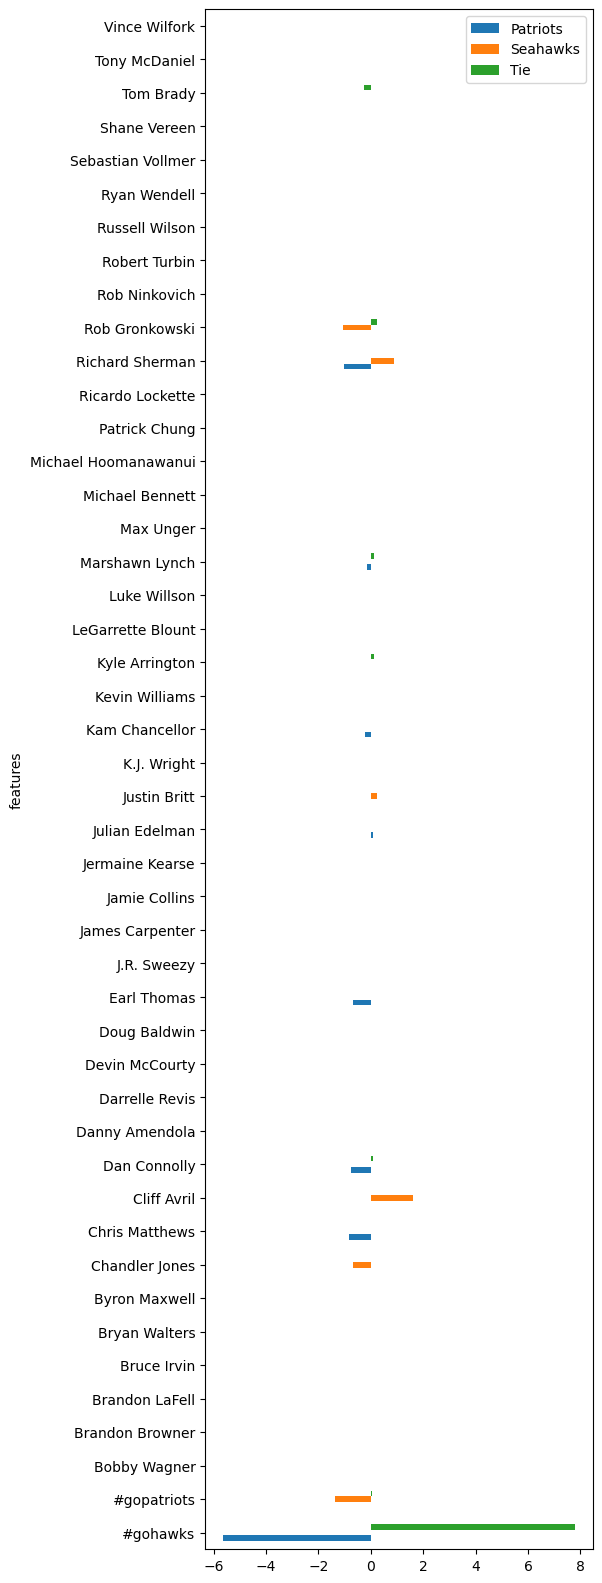

In [463]:
coeffs.plot(kind="barh", figsize=(5, 20))
plt.show()

In [422]:
forest_importances

player2
#gohawks          0.341693
#gopatriots       0.177001
Tom Brady         0.171126
Rob Gronkowski    0.118804
Russell Wilson    0.081863
Chris Matthews    0.072622
Marshawn Lynch    0.036891
dtype: float64

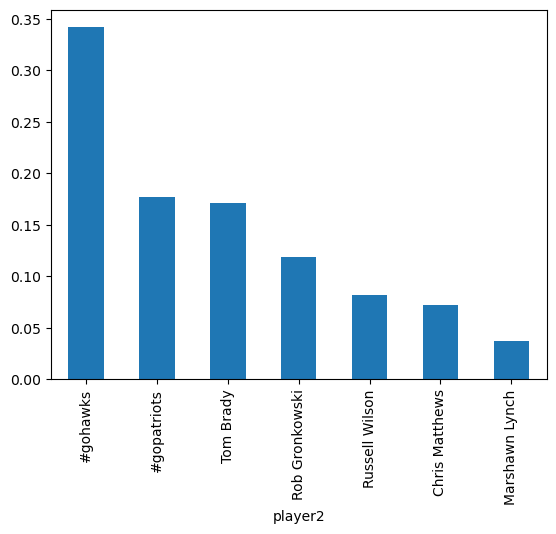

In [421]:
importances = cv_results['estimator'][0].feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [ ]:
# vader 109, 12 -- title, 0.2 drop
clf = RandomForestClassifier(n_estimators=40, max_depth=3, random_state=0, class_weight='balanced')

##### timeseries 

In [593]:
ts_cv = TimeSeriesSplit(
    n_splits=105,
    gap=0,
    max_train_size=3,
    test_size=1,
)

#https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [573]:
pd.DataFrame(y).T

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,108
leading,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,Tie,...,Seahawks,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots,Patriots


In [658]:
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
#clf = LogisticRegression(random_state=0)
clf = RandomForestClassifier(n_estimators=400, max_depth=1,random_state=0, class_weight='balanced')
#clf = MLPClassifier(max_iter=500)
cv_results = evaluate(clf, X, y, cv=10)
#print(cv_results)
cv_results['test_score'].mean()

0.5799999999999998

In [607]:
y.value_counts(normalize=True)

Tie         0.458716
Seahawks    0.321101
Patriots    0.220183
Name: leading, dtype: float64

In [579]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
all_splits

# delete splits where train same

[(array([1, 2, 3]), array([4])),
 (array([2, 3, 4]), array([5])),
 (array([3, 4, 5]), array([6])),
 (array([4, 5, 6]), array([7])),
 (array([5, 6, 7]), array([8])),
 (array([6, 7, 8]), array([9])),
 (array([7, 8, 9]), array([10])),
 (array([ 8,  9, 10]), array([11])),
 (array([ 9, 10, 11]), array([12])),
 (array([10, 11, 12]), array([13])),
 (array([11, 12, 13]), array([14])),
 (array([12, 13, 14]), array([15])),
 (array([13, 14, 15]), array([16])),
 (array([14, 15, 16]), array([17])),
 (array([15, 16, 17]), array([18])),
 (array([16, 17, 18]), array([19])),
 (array([17, 18, 19]), array([20])),
 (array([18, 19, 20]), array([21])),
 (array([19, 20, 21]), array([22])),
 (array([20, 21, 22]), array([23])),
 (array([21, 22, 23]), array([24])),
 (array([22, 23, 24]), array([25])),
 (array([23, 24, 25]), array([26])),
 (array([24, 25, 26]), array([27])),
 (array([25, 26, 27]), array([28])),
 (array([26, 27, 28]), array([29])),
 (array([27, 28, 29]), array([30])),
 (array([28, 29, 30]), array

In [248]:
# X.iloc[train_0]
# X.iloc[test_0]

In [505]:
y

0          Tie
1          Tie
2          Tie
3          Tie
4     Patriots
5     Patriots
6          Tie
7          Tie
8     Patriots
9          Tie
10         Tie
11         Tie
12         Tie
13    Seahawks
14    Seahawks
15    Seahawks
16    Seahawks
17    Seahawks
18    Seahawks
19    Seahawks
20    Patriots
21    Patriots
22    Patriots
Name: leading, dtype: object

In [570]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=4.0, max_depth=1, random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
cv_results['test_score'].mean()

/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 497, in fit
    y = self._validate_y(y, sample_weight)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 1268, in _validate_y


nan

In [392]:
cv_results['estimator'][0].feature_impo

GradientBoostingClassifier(learning_rate=4.0, max_depth=1, random_state=0)

In [515]:
clf = LogisticRegression(random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][0].coef_)

nan
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')
[[ 0.21705293 -0.01490791 -0.15416958 -0.27979171 -0.13495108  0.29015182
  -0.25077617  0.05871859  0.08071879  0.25886376  0.18389657  0.09427122
   0.01116446]]


/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gorkemcamli/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1554, in fit
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 'Tie'

-------------

In [500]:
clf = RandomForestClassifier(n_estimators=50, max_depth=10,random_state=0)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
print(cv_results['estimator'][10].feature_importances_)

0.5
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')
[0.06278555 0.06454509 0.08395751 0.06537171 0.06239344 0.12416161
 0.03039311 0.09038341 0.0610654  0.09484802 0.12253918 0.04208541
 0.09547057]


In [501]:
clf = MLPClassifier(hidden_layer_sizes=(100,),random_state=1, max_iter=300,  learning_rate_init=10.1,)
cv_results = evaluate(clf, X, y, cv=ts_cv)
#print(cv_results)
print(cv_results['test_score'].mean())
print(X.columns)
#print(cv_results['estimator'][10].feature_importances_)

0.4444444444444444
Index(['Dan Connolly', 'Earl Thomas', 'Jamie Collins', 'Julian Edelman',
       'Justin Britt', 'Kam Chancellor', 'Kevin Williams', 'Marshawn Lynch',
       'Nate Solder', 'Richard Sherman', 'Russell Wilson', 'Ryan Wendell',
       'Tom Brady'],
      dtype='object', name='players_str')


### Prediction Task 2: 

#### Find Fan based on tweet and user info (unbalanced data)



In [70]:
tweet_emt_df.shape

(155251, 61)

In [71]:
tweet_emt_df.columns

Index(['title', 'tweet.text', 'citation_date', 'hashtag', 'tweet.lang',
       'tweet.user.name', 'original_author.name', 'tweet.entities.hashtags',
       'tweet.entities.user_mentions', 'tweet.retweet_count',
       'tweet.favorite_count', 'tweet.user.followers_count',
       'tweet.user.friends_count', 'tweet.user.favourites_count',
       'author.followers', 'original_author.followers',
       'original_author.influence_level', 'metrics.ranking_score',
       'metrics.citations.influential', 'metrics.citations.total',
       'metrics.citations.matching', 'metrics.citations.replies',
       'metrics.impressions', 'author.influence_level', 'citation_date_fixed',
       'citation_date_year', 'citation_date_month', 'citation_date_day',
       'citation_date_hour', 'citation_date_rounded_hour', 'player',
       'player_count', 'players_str', 'game_status',
       'sent_nltk_vader_neg_title', 'sent_nltk_vader_neu_title',
       'sent_nltk_vader_pos', 'sent_nltk_vader_compound_title',
   

In [ ]:
'hashtag'

In [159]:
select_feats = [ 'hashtag',
        'tweet.retweet_count',
       'tweet.favorite_count', 'tweet.user.followers_count',
       'tweet.user.friends_count', 'tweet.user.favourites_count',
       'original_author.followers', 'original_author.influence_level', 
       #'metrics.ranking_score',
       'metrics.citations.influential', 'metrics.citations.total', 'metrics.citations.replies',
       'metrics.impressions', 'author.influence_level', 
       'player_count', 'game_status',
       'sent_nltk_vader_neg_title', 'sent_nltk_vader_neu_title',
       'sent_nltk_vader_pos', 'sent_nltk_vader_compound_title',
       'sent_nltk_vader_label_title', 
       'mention_count', 'hashtag_count']

In [160]:
pred2_data = tweet_emt_df[select_feats]

In [161]:
# get feature names by type
num_cols =  pred2_data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = pred2_data.select_dtypes(include=['object', 'category']).drop(['hashtag'], axis=1).columns

print(num_cols)
print(cat_cols)

Index(['tweet.retweet_count', 'tweet.favorite_count',
       'tweet.user.followers_count', 'tweet.user.friends_count',
       'tweet.user.favourites_count', 'original_author.followers',
       'original_author.influence_level', 'metrics.citations.influential',
       'metrics.citations.total', 'metrics.citations.replies',
       'metrics.impressions', 'author.influence_level', 'player_count',
       'sent_nltk_vader_neg_title', 'sent_nltk_vader_neu_title',
       'sent_nltk_vader_pos', 'sent_nltk_vader_compound_title',
       'mention_count', 'hashtag_count'],
      dtype='object')
Index(['game_status', 'sent_nltk_vader_label_title'], dtype='object')


In [162]:
pred2_data.sent_nltk_vader_label_title.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [163]:
game_status_categories = ['pre_game', 'during_game','after_game']
sent_nltk_vader_label_title_categories = ['negative','neutral', 'positive']
categs_order = [game_status_categories, sent_nltk_vader_label_title_categories]
    
def feature_transformer(data, numeric_feats, categ_feats, categs_order, scale=True):
    cat_transformer_ordinal = Pipeline(steps=[('ordinal_enc', OrdinalEncoder(categories=categs_order))])
    data[categ_feats] = cat_transformer_ordinal.fit_transform(data[categ_feats])
    if scale:
        num_transformer = Pipeline(steps=[('std_scaler', StandardScaler())])
        data[list(numeric_feats)+list(categ_feats)] = num_transformer.fit_transform(data[list(numeric_feats)+list(categ_feats)]) 
        
    return data


In [164]:
pred2_data_prep_df= pred2_data.copy()
pred2_data_prep_df = feature_transformer(data=pred2_data_prep_df, 
                                                numeric_feats=num_cols, 
                                                categ_feats=cat_cols,
                                                categs_order=categs_order,
                                                scale=True)
pred2_data_prep_df.head(4)

,hashtag,tweet.retweet_count,tweet.favorite_count,tweet.user.followers_count,tweet.user.friends_count,tweet.user.favourites_count,original_author.followers,original_author.influence_level,metrics.citations.influential,metrics.citations.total,...,author.influence_level,player_count,game_status,sent_nltk_vader_neg_title,sent_nltk_vader_neu_title,sent_nltk_vader_pos,sent_nltk_vader_compound_title,sent_nltk_vader_label_title,mention_count,hashtag_count
205,#gohawks,-0.004711,-0.003842,-0.050961,0.168955,0.568324,-0.051249,NaN,-0.062065,-0.025503,...,NaN,-0.443538,-0.528774,-0.416909,1.009292,-0.834414,-0.525855,-0.482967,0.526202,-0.769651
203,#gohawks,-0.004711,-0.003842,0.005093,0.501394,-0.192366,0.007502,-0.331246,-0.062065,0.022956,...,NaN,-0.443538,-0.528774,-0.416909,-0.929309,0.941515,1.639155,0.957730,-0.602815,-0.769651
208,#gohawks,-0.004711,-0.003842,-0.054964,0.319683,-0.226809,-0.055237,NaN,-0.062065,-0.025503,...,NaN,-0.443538,-0.528774,-0.416909,-0.995282,1.404801,0.729990,0.957730,0.526202,-0.769651
209,#gohawks,-0.004711,-0.003842,-0.025739,0.252414,-0.355308,-0.026825,NaN,-0.062065,-0.025503,...,NaN,-0.443538,-0.528774,-0.416909,-0.188378,0.718452,0.782141,0.957730,-0.602815,1.303109


In [165]:
pred2_features = list(num_cols)+list(cat_cols)

print(pred2_data_prep_df.shape)
pred2_data_prep_df_subsampled = pd.concat([pred2_data_prep_df[pred2_data_prep_df.hashtag=='#gopatriots'], 
                               pred2_data_prep_df[pred2_data_prep_df.hashtag=='#gohawks'].sample(10000)])
print(pred2_data_prep_df_subsampled.shape)


X_pred2 = pred2_data_prep_df[pred2_features]
X_pred2 = X_pred2.fillna(0)
y_pred2 = pred2_data_prep_df['hashtag']

X_pred2_subsampled = pred2_data_prep_df_subsampled[pred2_features]
X_pred2_subsampled = X_pred2_subsampled.fillna(0)
y_pred2_subsampled = pred2_data_prep_df_subsampled['hashtag']


(155251, 22)
(22884, 22)


In [166]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        return_train_score=True,
        return_estimator=True
    )
    return cv_results

In [167]:
y_pred2.value_counts(normalize=True)

#gohawks       0.917012
#gopatriots    0.082988
Name: hashtag, dtype: float64

In [171]:
#X_train, X_test, y_train, y_test = train_test_split(X_pred2, y_pred2, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_pred2_subsampled, y_pred2_subsampled, test_size=0.3, random_state=42)
print(y_train.value_counts())
print(y_test.value_counts())

#gopatriots    8990
#gohawks       7028
Name: hashtag, dtype: int64
#gopatriots    3894
#gohawks       2972
Name: hashtag, dtype: int64


In [179]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0)
#clf = LogisticRegression(random_state=0, class_weight='balanced')
#clf = RandomForestClassifier(random_state=0, class_weight='balanced')
#clf = MLPClassifier(hidden_layer_sizes=(100,100),max_iter=200, learning_rate_init=0.6)

cv_results = evaluate(clf, X=X_train, y=y_train, cv=10)
#print(cv_results)
print(cv_results['test_score'].mean())

"""
X_train, X_test, y_train, y_test = train_test_split(X_pred2, y_pred2, test_size=0.3, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds)
print(Counter(preds))
print(clf.score(X_test, y_test))
print(X.columns)
#print(clf.coef_) #.feature_importances_)
#print(cv_results['estimator'][0].coef_) #.feature_importances_)

#print(clf.feature_importances_) #.feature_importances_)
#print(cv_results['estimator'][0].feature_importances_) #.feature_importances_)
"""

0.6526399308796546


"\nX_train, X_test, y_train, y_test = train_test_split(X_pred2, y_pred2, test_size=0.3, random_state=42)\nclf.fit(X_train, y_train)\npreds = clf.predict(X_test)\nprint(preds)\nprint(Counter(preds))\nprint(clf.score(X_test, y_test))\nprint(X.columns)\n#print(clf.coef_) #.feature_importances_)\n#print(cv_results['estimator'][0].coef_) #.feature_importances_)\n\n#print(clf.feature_importances_) #.feature_importances_)\n#print(cv_results['estimator'][0].feature_importances_) #.feature_importances_)\n"

In [180]:
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(preds)
print(Counter(preds))
print(clf.score(X_test, y_test))

['#gohawks' '#gopatriots' '#gopatriots' ... '#gohawks' '#gopatriots'
 '#gohawks']
Counter({'#gopatriots': 4001, '#gohawks': 2865})
0.6575881153510049


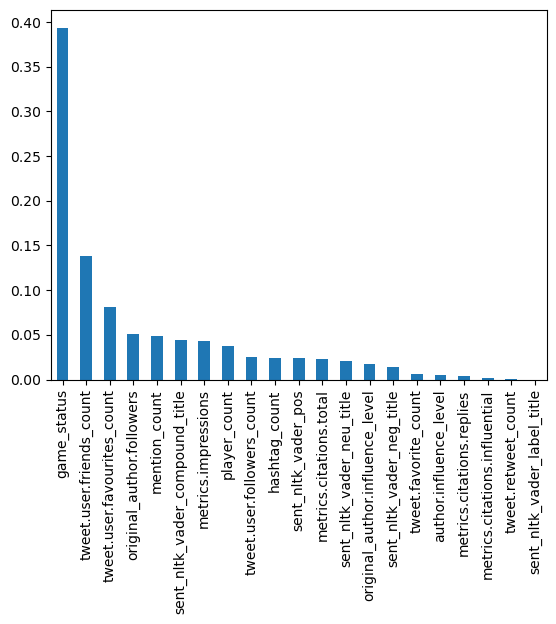

In [181]:
importances = clf.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False, inplace=True)
forest_importances.plot.bar()
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
plt.show()

In [158]:
X_train['metrics.ranking_score'].describe()

count    16018.000000
mean         0.057305
std          0.955287
min         -1.751756
25%         -0.387773
50%         -0.160130
75%          0.036754
max          5.506275
Name: metrics.ranking_score, dtype: float64

### Prediction Task 3: 

#### Find impression of a tweet based on tweet and user features.

# Emojis -- not related for now.

__Are emojis all we need?__

How emojis used on tweets can be helpful on:
- Understanding sentiments/emotions of the fans during the game and for players?
    - nltk, emoji sentiments, bert
    
- Finding the most important times of the game? (emoji count vs time correlation, using emojis correlate score?, )
- Understanding reach/impressions/retweets of the game? (predict retweets, impressions and favs from the emoji information or vice versa.)
- can you tell mvp based on emoji count and emojis used.

Can an emoji tell more than 280 characters?

https://www.kaggle.com/eliasdabbas/emoji-data-descriptions-codepoints?select=emoji_df.csv
http://kt.ijs.si/data/Emoji_sentiment_ranking/index.html
https://pypi.org/project/emosent-py/
https://github.com/abushoeb/EmoTag/blob/master/data/EmoTag1200-scores-details.csv



In [64]:
def get_emoji_df(df):

    tweets = df.drop_duplicates().values.tolist()

    tweets  = [x for x in tweets if not x.startswith('RT')]

    
    try:
        # UCS-4
        e = re.compile(u'[\U00010000-\U0010ffff]')
    except re.error:
        # UCS-2
        e = re.compile(u'[\uD800-\uDBFF][\uDC00-\uDFFF]')

    emojis = []
    '''
    for i, x in enumerate(tweets):
        match  = e.search(x)
        if match:
            em_group = match.group()
            print(em_group, x, '\n')
            emojis.append(em_group)
    
    '''
    emoji_pattern = re.compile(u"(["                     # .* removed
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                                "])", flags= re.UNICODE)             # + removed

    for sent in tweets:
        emojis_found = ' '.join(re.findall(emoji_pattern, sent))
        #if emojis_found:
            #print(emojis_found, sent, '\n')
        emojis.append(emojis_found)

    dfe =  pd.DataFrame(emojis, columns=['emojis'])
    #display(pd.Series(' '.join(dfe['text']).lower().split()).value_counts()[:25])
    return dfe

x_df = get_emoji_df(df=tweet_dfs['gopatriots']['tweet.text'])
x_df['emoji_count'] = x_df['emojis'].apply(lambda x: len(x.split(' ')) if x else 0)
#x_df_hawks = get_emoji_df(df=tweet_dfs['gohawks']['title'])


# https://medium.com/swlh/%EF%B8%8Fdoes-emoji-use-correlate-with-twitter-engagement-388775467be

In [66]:
x_df[x_df.emoji_count!=0]

,emojis,emoji_count
1,😍 🙌 🏈 💙,4
7,🏈,1
10,😍 😍,2
12,👍,1
26,👊 🏈,2
...,...,...
22120,🏈 💋,2
22130,😂 😂 😂 🏈,4
22131,🏈 👊,2
22135,🏈,1


In [69]:
x_df_hawks = get_emoji_df(df=tweet_dfs['gohawks']['title'])
x_df_hawks['emoji_count'] = x_df_hawks['emojis'].apply(lambda x: len(x.split(' ')) if x else 0)
x_df_hawks[x_df_hawks.emoji_count!=0]

,emojis,emoji_count
10,💙 💚,2
11,😁,1
13,💙 💚,2
17,🌞,1
19,😎,1
...,...,...
162272,🏉 🏉 🏈 🏀 🎨 🎼 👑 🏰,8
162273,🎥 😜 😝 🏈 🏀 🏉 🎨 🎼 👑 🏰,10
162276,🎥 😜 😝 👀 🏈 🏀 🏉 🎨 🎼 👑 🏰,11
162283,😄 💖,2


In [78]:
emoji_counts = Counter(' '.join(x_df.emojis.tolist()).split(' '))
del emoji_counts['']
print(len(emoji_counts))
emoji_counts.most_common(30)

228


[('🏈', 2337),
 ('💙', 733),
 ('👏', 543),
 ('😂', 485),
 ('🙌', 381),
 ('🎉', 350),
 ('😍', 321),
 ('🏆', 238),
 ('💪', 212),
 ('🏉', 157),
 ('👊', 147),
 ('👍', 144),
 ('👌', 136),
 ('🇺', 134),
 ('🇸', 134),
 ('😁', 119),
 ('😭', 113),
 ('🙏', 112),
 ('😱', 77),
 ('😃', 74),
 ('😏', 64),
 ('😎', 63),
 ('😜', 62),
 ('😘', 60),
 ('😊', 60),
 ('🔵', 60),
 ('😄', 59),
 ('😉', 58),
 ('🎊', 56),
 ('🔴', 55)]

In [49]:

df_cols = list(tweet_dfs['gopatriots'].columns)
selected_cols = [ col for col in df_cols if 'original_author' in col]
tweet_dfs['gopatriots'][selected_cols]

,original_author.author_img,original_author.description,original_author.url,original_author.nick,original_author.followers,original_author.image_url,original_author.type,original_author.name,original_author.influence_level
0,http://pbs.twimg.com/profile_images/5512012677...,Follow me for News on Boston Sports Teams! #G...,http://twitter.com/nesportsfan1106,nesportsfan1106,3811.0,http://pbs.twimg.com/profile_images/5512012677...,twitter,Boston Sports Fan,NaN
1,http://pbs.twimg.com/profile_images/5432108023...,My life: @Patriots ❤#PatriotsNation/ Celtics/R...,http://twitter.com/87patriots,87patriots,1163.0,http://pbs.twimg.com/profile_images/5432108023...,twitter,Mrs. Gronk,NaN
2,http://pbs.twimg.com/profile_images/4286917041...,a new york city nutritionist at megan wolf nut...,http://twitter.com/meganwolfrd,meganwolfrd,2124.0,http://pbs.twimg.com/profile_images/4286917041...,twitter,"megan wolf, ms rd",7.0
3,http://pbs.twimg.com/profile_images/5055340279...,Student run account covering \nAmerican Herita...,http://twitter.com/ah__athletics,ah__athletics,1216.0,http://pbs.twimg.com/profile_images/5055340279...,twitter,American Heritage,NaN
4,http://pbs.twimg.com/profile_images/5534009031...,"Soy esquizofrénico paranoide, que mola más que...",http://twitter.com/jossflacco,jossflacco,1165.0,http://pbs.twimg.com/profile_images/5534009031...,twitter,Necromancer.,0.0
...,...,...,...,...,...,...,...,...,...
23506,http://pbs.twimg.com/profile_images/5584087520...,Estudiante de periodismo en la Aficionado a la...,http://twitter.com/gustavoalohac10,gustavoalohac10,4.0,http://pbs.twimg.com/profile_images/5584087520...,twitter,Gustavo Rivera,NaN
23507,http://pbs.twimg.com/profile_images/5561924210...,? P?????? ? D??? ? N? S?? ? B???????? ? ? N?...,http://twitter.com/perla19camilaca,perla19camilaca,24.0,http://pbs.twimg.com/profile_images/5561924210...,twitter,Perla Calvo,NaN
23508,http://pbs.twimg.com/profile_images/5572943616...,"From Boston, but in Seattle via a 17 yr journe...",http://twitter.com/davidofseattle,davidofseattle,3459.0,http://pbs.twimg.com/profile_images/5572943616...,twitter,David Dallaire,1.0
23509,http://pbs.twimg.com/profile_images/5127646825...,Anuncios Clasificados Gratis Cancún | Asesor d...,http://twitter.com/mikeintowncun,mikeintowncun,854.0,http://pbs.twimg.com/profile_images/5127646825...,twitter,Anuncios Gratis CUN,1.0


In [144]:
player = 'Tom Brady'
tom_brady_text_df = tweet_dfs['gopatriots'][tweet_dfs['gopatriots']['title'].str.contains(player)]
tom_brady_text_df['len'] = tom_brady_text_df['title'].apply(lambda x: len(str(x)))

tom_brady_text_df['word_count'] = tom_brady_text_df['title'].apply(lambda x: len(x.split(' ')))
#tom_brady_text_df = tom_brady_text_df.sort_values(by=['metrics.citations.total'],ascending=False)
#tom_brady_text_df['word_cum_sum'] = tom_brady_text_df['word_count'].cumsum()
#tom_brady_text_df[['tweet.text','metrics.citations.total','len','word_count','word_cum_sum']]
tom_brady_text_df.shape

/var/folders/t3/qmdm09ls3m5352tkfm05z4hh0000gn/T/ipykernel_18054/256644787.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tom_brady_text_df['len'] = tom_brady_text_df['title'].apply(lambda x: len(str(x)))
/var/folders/t3/qmdm09ls3m5352tkfm05z4hh0000gn/T/ipykernel_18054/256644787.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tom_brady_text_df['word_count'] = tom_brady_text_df['title'].apply(lambda x: len(x.split(' ')))


(360, 12)

In [68]:
tom_brady_text_df[tom_brady_text_df['word_cum_sum']< 500].shape

(21, 120)

In [69]:
tom_brady_text_list= tom_brady_text_df.head(21)['tweet.text'].tolist()
tom_brady_text = '. '.join(tom_brady_text_list)
tom_brady_text

"It's SuperBowl Sunday 🏈 #Patriots vs #Seahawks Tom Brady vs Russell Wilson #SB49 #SuperBowlXLIX @NFL #NEvsSEA #GoPatriots #GoPats. I'm a Pats fan who loves Richard Sherman and Russell Wilson #truth #SuperBowlXLIX #GoPatriots. Even though Russell Wilson is from Richmond he still went to Collegiate... #GoPatriots. Can someone shut Russell Wilson up. He's so fake and unlikeable it's ridiculous. #gopatriots. Russell Wilson knows Revis Island is a dangerous place to visit. It's why he hasn't thrown that way. #GoPatriots. #patriots #GoPatriots Belichick 1/26: 'Russell Wilson is a winner' http://t.co/HT2tnb4TpF. Russell Wilson is the real MVP #gopatriots. I swear, w/ the exception of Russell Wilson....I can't stand the @Seahawks. &amp; I'm ecstatic that they loss! #GoPatriots 👍🏆🏈. If Russell Wilson doesn't pull this off, everyone at work will be upset! Hahaha #wearehuskies #GoPatriots #bradyistheman. I just can't take all the cheesy Russell Wilson quotes that would follow a Russell Wilson co

In [ ]:
# to do clean links, create a column contains link true. 